In [ ]:
# Start writing code here...

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from time import time 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

#PyTorch ve sklearn kütüphanelerinin yüklenmesini sağlar. 
#Sklearn'in CountVectorizer sınıfı, metin verilerini vektörlere dönüştürmek için kullanılır.

In [ ]:

# Verileri yükleme ve işleme
#PyTorch'ta, bir tensorü NumPy dizisine dönüştürmek için to_numpy() fonksiyonu kullanılır. 
#Bu fonksiyon, bir PyTorch tensorünü NumPy ndarray formatına dönüştürür.

train_df = pd.read_csv('cure_the_princess_train.csv').to_numpy()
test_df = pd.read_csv('cure_the_princess_test.csv').to_numpy()
validation_df = pd.read_csv('cure_the_princess_validation.csv').to_numpy()



In [ ]:

#Bir veri kümesini özellikler (features) ve hedef değişken (target) olarak ayırarak, eğitim, doğrulama ve test veri setleri için ayrıştırır.
#Özellikler (features) genellikle modelin girdisi olarak kullanılan veri özellikleridir.
train_features = train_df[:,:-1]
validation_features = validation_df[:,:-1]
test_features = test_df[:,:-1]
#"train_features", "validation_features" ve "test_features" değişkenleri, ilgili veri kümesinin özellik sütunlarını içeren alt kümelerdir.


#Hedef değişken (target) ise, modelin tahmin etmeye çalıştığı çıktıdır.
train_targets = train_df[:,-1]
validation_targets = validation_df[:,-1]
test_targets = test_df[:,-1]
#"train_targets", "validation_targets" ve "test_targets" değişkenleri ise, ilgili veri kümesinin son sütununu içeren alt kümelerdir ve hedef değişkenleri içerir.

In [ ]:
SEED = 190401057 
torch.manual_seed(SEED)

In [ ]:
#Cross-entropy loss fonksiyonu ve SGD (Stochastic Gradient Descent) optimizeri kullanılarak bir öğrenme modeli oluşturulur.
learning_rate = 0.001
num_epochs = 250  #epoch değişcek sürekli
BATCH_SIZE = 16
patience = 5

In [ ]:
# PyTorch modelini oluşturduk
#MLP adında bir PyTorch modeli tanımlanır. Model, girdi boyutu, gizli katman boyutları ve çıktı boyutuna göre özelleştirilir. 
#Model, nn.Linear, nn.ReLU ve nn.Sigmoid gibi PyTorch modüllerini kullanarak oluşturulur.

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        return out

In [ ]:

class PrincessDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.targets[idx]
        return x, y


In [ ]:

## train, validation ve test verileri yüklenir
train_set = PrincessDataset(train_features, train_targets)
validation_set = PrincessDataset(validation_features, validation_targets)
test_set = PrincessDataset(test_features, test_targets)

# train, validation ve test verileri yükleyicileri oluşturulur
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)




In [ ]:

#İlk  hidden layer’da  100,  ikinci  hidden  layer’da  50  nöron  olsun.
input_size = train_features.shape[1] 
hidden_size1 = 100
hidden_size2 = 50
output_size = 1
model = MLP(input_size, hidden_size1, hidden_size2, output_size)

l2_lambda = 0.001
criterion = nn.BCEWithLogitsLoss()  # sigmoid yok, loss function olarak BCEWithLogitsLoss kullanılıyor
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)


In [ ]:
def early_stopping(val_loss, model, best_val_loss, patience_counter, patience):
    # Early stopping için gerekli değişkenler

    # Early stopping kontrolü
    val_score = val_loss
    if best_val_loss is None:
        best_val_loss = val_score # hafızada patience boyu tutmaya başla
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: # patience counter
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            return best_val_loss, patience_counter
    else:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt") # to keep the best model
        patience_counter = 0
        
    return best_val_loss, patience_counter

In [ ]:
SEED = 190401057 
torch.manual_seed(SEED)

#Modeli eğitmek için train() fonksiyonu tanımlanır. 
#Bu fonksiyon, verilen sayıda epoch için modeli eğitir ve eğitim sırasında kayıp ve doğruluk oranlarını saklar.
#train() fonksiyonu, her bir epoch'ta eğitim setindeki her bir batch üzerinde modeli eğitmek için kullanılır.
#Her epoch'ta, modelin doğruluğunu ve kaybını validation setinde hesaplar ve kayıp ve doğruluk oranlarını saklar.

this_moment = time()#kodun belirli bir noktasında ne kadar süre geçtiğini hesaplamak için kullanılır

# Modeli eğitmek için bir fonksiyon tanımladık
train_losses = []
valid_losses = []


best_val_loss=0.0
patience_counter = 0




    # Modeli eğitim moduna alıyoruz
for epoch in range(num_epochs):
    # Train the model
    train_loss = 0.0
    train_count=0.0

        # Batch'ler üzerinde eğitim yapıyoruz
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)
        optimizer.zero_grad()  # Gradyanları sıfırlıyoruz

        outputs = model(inputs) # Verileri tensörlere dönüştürüyoruz
        outputs = outputs.squeeze()#tensörde boyutu 1 olan boyutları kaldırmak için kullandık
        loss = criterion(outputs, labels) # Kayıp hesaplıyoruz
        loss.backward() # Kaybın geriye yayılımı
        optimizer.step() # Gradyan tabanlı optimizasyon işlemi

        train_count+=1.0
        train_loss += loss.item() #* inputs.size(0) #(0) # Train accuracy hesabı

        
        
    # Her epoch sonunda doğrulama seti üzerinde modelin performansını değerlendiriyoruz
    valid_loss = 0.0  

    with torch.no_grad():
        model.eval()
        for inputs, labels in validation_loader:#valloader
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)  # Doğrulama seti için loss hesabı 

        
    model.train()

    # calculate metrics
    train_loss /= train_count
    valid_loss /= len(validation_loader)
        
        
    # Her epoch sonunda kayıp ve doğruluk oranlarını listelere ekliyoruz
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

        

    # Her epoch sonunda kayıp ve doğruluk oranlarını yazdırıyoruz
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f},  Validation Loss: {valid_loss:.4f}")
    # Early stopping
    best_val_loss, patience_counter = early_stopping(valid_loss, model, best_val_loss, patience_counter, patience)
    if patience_counter == patience:
        print("Early stopping triggered.")
        break

    # log
    print("Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch+1, train_loss, valid_loss))


Epoch 1/250, Train Loss: 0.7221,  Validation Loss: 11.0813
Earlystopping Patience Counter: 1
Epoch: 1, Training Loss: 0.7221, Validation Loss: 11.0813
Epoch 2/250, Train Loss: 0.7023,  Validation Loss: 10.9230
Earlystopping Patience Counter: 2
Epoch: 2, Training Loss: 0.7023, Validation Loss: 10.9230
Epoch 3/250, Train Loss: 0.6969,  Validation Loss: 10.8453
Earlystopping Patience Counter: 3
Epoch: 3, Training Loss: 0.6969, Validation Loss: 10.8453
Epoch 4/250, Train Loss: 0.6928,  Validation Loss: 10.8009
Earlystopping Patience Counter: 4
Epoch: 4, Training Loss: 0.6928, Validation Loss: 10.8009
Epoch 5/250, Train Loss: 0.6905,  Validation Loss: 10.7656
Earlystopping Patience Counter: 5
Early stopping triggered.


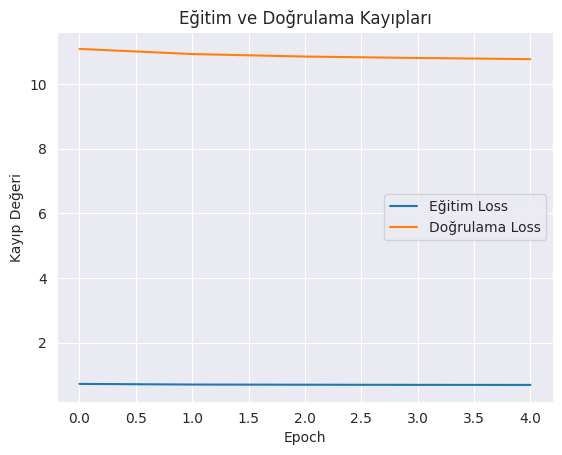

Finished Training in: 5.549046277999878 second.


In [ ]:
# Kayıp grafiği
sns.set_style("darkgrid")
plt.plot(train_losses, label="Eğitim Loss")
plt.plot(valid_losses, label="Doğrulama Loss")
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp Değeri')
plt.legend()
plt.show()
print('Finished Training in: ' + str(time() - this_moment) + ' second.' )


In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)
        outputs = model(inputs)
        outputs = outputs.squeeze()
        predicted = torch.round(outputs)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1 Score: {:.4f}".format(f1))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Accuracy: 51.55%
F1 Score: 0.0833
Precision: 0.8500
Recall: 0.0438

Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      0.99      0.67       384
         1.0       0.85      0.04      0.08       388

    accuracy                           0.52       772
   macro avg       0.68      0.52      0.38       772
weighted avg       0.68      0.52      0.38       772



Epoch 1/250, Train Loss: 0.6762,  Validation Loss: 0.6191
Earlystopping Patience Counter: 1
Epoch: 1, Training Loss: 0.6762, Validation Loss: 0.6191
Epoch 2/250, Train Loss: 0.6063,  Validation Loss: 0.5707
Earlystopping Patience Counter: 2
Epoch: 2, Training Loss: 0.6063, Validation Loss: 0.5707
Epoch 3/250, Train Loss: 0.5690,  Validation Loss: 0.5416
Earlystopping Patience Counter: 3
Epoch: 3, Training Loss: 0.5690, Validation Loss: 0.5416
Epoch 4/250, Train Loss: 0.5366,  Validation Loss: 0.5035
Earlystopping Patience Counter: 4
Epoch: 4, Training Loss: 0.5366, Validation Loss: 0.5035
Epoch 5/250, Train Loss: 0.5098,  Validation Loss: 0.4742
Earlystopping Patience Counter: 5
Epoch: 5, Training Loss: 0.5098, Validation Loss: 0.4742
Epoch 6/250, Train Loss: 0.4797,  Validation Loss: 0.4481
Earlystopping Patience Counter: 6
Epoch: 6, Training Loss: 0.4797, Validation Loss: 0.4481
Epoch 7/250, Train Loss: 0.4582,  Validation Loss: 0.4423
Earlystopping Patience Counter: 7
Epoch: 7, Trai

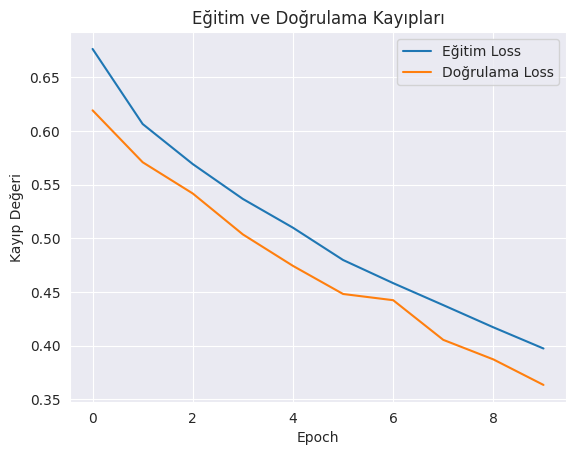

Finished Training in: 1.7676517963409424 second.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from time import time 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim


#PyTorch ve sklearn kütüphanelerinin yüklenmesini sağlar. 
#Sklearn'in CountVectorizer sınıfı, metin verilerini vektörlere dönüştürmek için kullanılır.
# Verileri yükleme ve işleme
#PyTorch'ta, bir tensorü NumPy dizisine dönüştürmek için to_numpy() fonksiyonu kullanılır. 
#Bu fonksiyon, bir PyTorch tensorünü NumPy ndarray formatına dönüştürür.

train_df = pd.read_csv('cure_the_princess_train.csv').to_numpy()
test_df = pd.read_csv('cure_the_princess_test.csv').to_numpy()
validation_df = pd.read_csv('cure_the_princess_validation.csv').to_numpy()
#Bir veri kümesini özellikler (features) ve hedef değişken (target) olarak ayırarak, eğitim, doğrulama ve test veri setleri için ayrıştırır.
#Özellikler (features) genellikle modelin girdisi olarak kullanılan veri özellikleridir.
train_features = train_df[:,:-1]
validation_features = validation_df[:,:-1]
test_features = test_df[:,:-1]
#"train_features", "validation_features" ve "test_features" değişkenleri, ilgili veri kümesinin özellik sütunlarını içeren alt kümelerdir.


#Hedef değişken (target) ise, modelin tahmin etmeye çalıştığı çıktıdır.
train_targets = train_df[:,-1]
validation_targets = validation_df[:,-1]
test_targets = test_df[:,-1]
#"train_targets", "validation_targets" ve "test_targets" değişkenleri ise, ilgili veri kümesinin son sütununu içeren alt kümelerdir ve hedef değişkenleri içerir.

SEED = 190401057 
torch.manual_seed(SEED)

#Cross-entropy loss fonksiyonu ve SGD (Stochastic Gradient Descent) optimizeri kullanılarak bir öğrenme modeli oluşturulur.
learning_rate = 0.001
num_epochs = 250  #epoch değişcek sürekli
BATCH_SIZE = 16
patience = 10

# PyTorch modelinizi oluşturuldu
#MLP adında bir PyTorch modeli tanımlanır. Model, girdi boyutu, gizli katman boyutları ve çıktı boyutuna göre özelleştirilir. 
#Model, nn.Linear, nn.ReLU ve nn.Sigmoid gibi PyTorch modüllerini kullanarak oluşturulur.


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))
        return out

class PrincessDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.targets[idx]
        return x, y

## train, validation ve test verileri yüklenir
train_set = PrincessDataset(train_features, train_targets)
validation_set = PrincessDataset(validation_features, validation_targets)
test_set = PrincessDataset(test_features, test_targets)

# train, validation ve test verileri yükleyicileri oluşturulur
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

#İlk  hidden layer’da  100,  ikinci  hidden  layer’da  50  nöron  olsun.
input_size = train_features.shape[1] 
hidden_size1 = 100
hidden_size2 = 50
output_size = 1
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
def early_stopping(val_loss, model, best_val_loss, patience_counter, patience):
    # Early stopping için gerekli değişkenler

    # Early stopping kontrolü
    val_score = val_loss
    if best_val_loss is None:
        best_val_loss = val_score # hafızada patience boyu tutmaya başla
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: # patience counter
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        if patience_counter == patience:
            return best_val_loss, patience_counter
    else:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt") # to keep the best model
        patience_counter = 0
        
    return best_val_loss, patience_counter
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)  #learning rate de değişecek



#Modeli eğitmek için train() fonksiyonu tanımlanır. 
#Bu fonksiyon, verilen sayıda epoch için modeli eğitir ve eğitim sırasında kayıp ve doğruluk oranlarını saklar.
#train() fonksiyonu, her bir epoch'ta eğitim setindeki her bir batch üzerinde modeli eğitmek için kullanılır.
#Her epoch'ta, modelin doğruluğunu ve kaybını validation setinde hesaplar ve kayıp ve doğruluk oranlarını saklar.
#Her 10 batch'te bir eğitim sırasında kayıp ve doğruluk oranlarını yazdırır.

this_moment = time()#kodun belirli bir noktasında ne kadar süre geçtiğini hesaplamak için kullanılır

# Modeli eğitmek için bir fonksiyon tanımladık
train_losses = []
valid_losses = []
#list_train_loss, list_val_loss = [], []

best_val_loss=0.0
patience_counter = 0

# Modeli eğitmek için bir fonksiyon tanımladık


    # Modeli eğitim moduna alıyoruz
for epoch in range(num_epochs):
    # Train the model
    train_loss = 0.0
    train_count=0.0

        # Batch'ler üzerinde eğitim yapıyoruz
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(torch.float)
        labels = labels.to(torch.float)
        optimizer.zero_grad()  # Gradyanları sıfırlıyoruz

        outputs = model(inputs) # Verileri tensörlere dönüştürüyoruz
        outputs = outputs.squeeze()#tensörde boyutu 1 olan boyutları kaldırmak için kullandık
        loss = criterion(outputs, labels) # Kayıp hesaplıyoruz
        loss.backward() # Kaybın geriye yayılımı
        optimizer.step() # Gradyan tabanlı optimizasyon işlemi

        train_count+=1.0
        train_loss += loss.item() #* inputs.size(0) #(0) # Train accuracy hesabı

        
        
        # Her epoch sonunda doğrulama seti üzerinde modelin performansını değerlendiriyoruz
    valid_loss = 0.0  #val_loss

    with torch.no_grad():
        model.eval()
        for inputs, labels in validation_loader:#valloader
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            valid_loss += loss.item() #* inputs.size(0)  # Doğrulama seti için loss hesabı 

        
    model.train()

        # calculate metrics
    train_loss /= train_count
    valid_loss /= len(validation_loader)
        
        
        # Her epoch sonunda kayıp ve doğruluk oranlarını listelere ekliyoruz
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

        

    # Her epoch sonunda kayıp ve doğruluk oranlarını yazdırıyoruz
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f},  Validation Loss: {valid_loss:.4f}")
    # Early stopping
    best_val_loss, patience_counter = early_stopping(valid_loss, model, best_val_loss, patience_counter, patience)
    if patience_counter == patience:
        print("Early stopping triggered.")
        break

    # log
    print("Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}".format(epoch+1, train_loss, valid_loss))




# Kayıp grafiği
sns.set_style("darkgrid")
plt.plot(train_losses, label="Eğitim Loss")
plt.plot(valid_losses, label="Doğrulama Loss")
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp Değeri')
plt.legend()
plt.show()
print('Finished Training in: ' + str(time() - this_moment) + ' second.' )

In [4]:
# Modeli GPU'ya taşıma
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
out = out.to(device)

# GPU'da modeli çalıştırma
output = model(data)

# Çıktıyı CPU'ya taşıma
output = output.to("cpu")

NameError: name 'out' is not defined

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(torch.float32)
        labels = labels.to(torch.float32)
        outputs = model(inputs)
        outputs = outputs.squeeze()
        predicted = torch.round(outputs)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("F1 Score: {:.4f}".format(f1))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("\nClassification Report:\n", classification_report(y_true, y_pred))


Accuracy: 94.56%
F1 Score: 0.9441
Precision: 0.9753
Recall: 0.9149

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.98      0.95       384
         1.0       0.98      0.91      0.94       388

    accuracy                           0.95       772
   macro avg       0.95      0.95      0.95       772
weighted avg       0.95      0.95      0.95       772



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=51c5fb45-009f-4d6d-bbaa-ad7e12cfcdb4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>